# Load organizer data

In [109]:
import glob
import pandas as pd
import polars as pl
import numpy as np

organizer_prediction_filepaths = glob.glob('predictions/full_v4_organizer*.csv')
organizer_prediction_dfs = [pd.read_csv(filepath) for filepath in organizer_prediction_filepaths]

mean_organizer_predictions = np.mean(
    [df['prediction'].values for df in organizer_prediction_dfs], 
    axis=0
)

print(mean_organizer_predictions)
print(np.mean(mean_organizer_predictions), np.std(mean_organizer_predictions))

[-0.30460678 -0.28672099 -0.13130407 ...  0.45213715  0.45279479
  0.18390457]
0.04493549669958323 0.5474997858910042


In [110]:
organizer_df = pl.read_csv('../data/from_organizers/train.csv').to_pandas()

OUTCOME_COUNT_COLS = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
organizer_outcome_counts = organizer_df[OUTCOME_COUNT_COLS].values

organizer_labels = organizer_df['utility_agent1'].values

In [111]:
print(organizer_outcome_counts)
print(organizer_labels)

print(np.mean(organizer_labels), np.std(organizer_labels))

[[ 4  0 11]
 [ 5  0 10]
 [ 7  0  8]
 ...
 [11  3  1]
 [24  2  4]
 [ 9  1  5]]
[-0.46666667 -0.33333333 -0.06666667 ...  0.66666667  0.66666667
  0.26666667]
0.04439766262399326 0.622845637974197


# Load extra data

In [112]:
extra_prediction_filepaths = glob.glob('predictions/full_v4_extra*.csv')
extra_prediction_dfs = [pd.read_csv(filepath) for filepath in extra_prediction_filepaths]

mean_extra_predictions = np.mean(
    [df['prediction'].values for df in extra_prediction_dfs], 
    axis=0
)

print(mean_extra_predictions)
print(np.mean(mean_extra_predictions), np.std(mean_extra_predictions))

[ 0.61119744 -0.17589667 -0.53350942 ...  0.79209699  0.83346089
  0.74507928]
0.08287905538227157 0.5380417590312897


In [113]:
extra_df = pl.read_csv('../GAVEL/generated_csvs/complete_datasets/2024-10-23_15-10-16.csv').to_pandas()

extra_labels = extra_df['utility_agent1'].values

In [114]:
print(extra_labels)

print(np.mean(extra_labels), np.std(extra_labels))

[ 1.  0. -1. ...  1.  1.  1.]
0.08366372980910426 0.669549028530881


# Investigate organizer errors

In [115]:
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error

print(pearsonr(mean_organizer_predictions, organizer_labels))
print(root_mean_squared_error(mean_organizer_predictions, organizer_labels))

print()
print(pearsonr(mean_organizer_predictions.clip(-1,1), organizer_labels))
print(root_mean_squared_error(mean_organizer_predictions.clip(-1,1), organizer_labels))

PearsonRResult(statistic=0.9177045145445316, pvalue=0.0)
0.24860430482313603

PearsonRResult(statistic=0.9197366062416603, pvalue=0.0)
0.24701442771521565


In [116]:
simulation_outcomes = []
for outcome_counts in organizer_outcome_counts:
    trials = [
        np.random.choice([1, 0, -1], p=outcome_counts/np.sum(outcome_counts))
        for _ in range(sum(outcome_counts))
    ]
    simulation_outcomes.append(np.mean(trials))

print(pearsonr(simulation_outcomes, organizer_labels))
print(root_mean_squared_error(simulation_outcomes, organizer_labels))

PearsonRResult(statistic=0.9632457254726857, pvalue=0.0)
0.1736436574886082


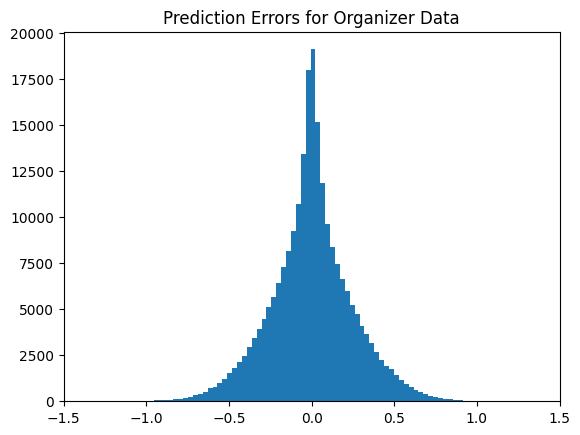

In [117]:
from matplotlib import pyplot as plt

prediction_errors = mean_organizer_predictions - organizer_labels

plt.hist(prediction_errors, bins=100)

plt.title('Prediction Errors for Organizer Data')
plt.xlim(-1.5, 1.5)

plt.show()

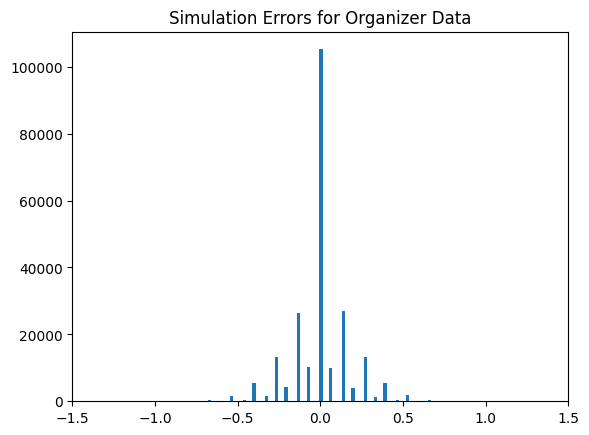

In [118]:
simulation_errors = simulation_outcomes - organizer_labels

plt.hist(simulation_errors, bins=100)

plt.title('Simulation Errors for Organizer Data')
plt.xlim(-1.5, 1.5)

plt.show()

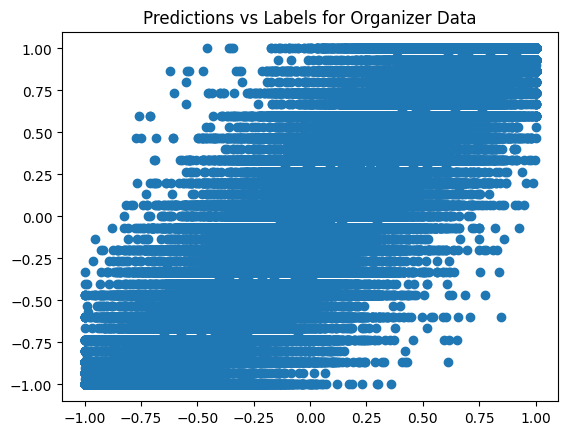

In [119]:
plt.scatter(mean_organizer_predictions.clip(-1,1), organizer_labels)
plt.title('Predictions vs Labels for Organizer Data')
plt.show()

# Check hybrid simulation + inference error

In [120]:
simulation_outcomes = []
for outcome_counts in organizer_outcome_counts:
    trials = [
        np.random.choice([1, 0, -1], p=outcome_counts/np.sum(outcome_counts))
        for _ in range(sum(outcome_counts))
    ]
    simulation_outcomes.append(np.mean(trials))

print(pearsonr(simulation_outcomes, organizer_labels))
print(root_mean_squared_error(simulation_outcomes, organizer_labels))

PearsonRResult(statistic=0.9633770031143343, pvalue=0.0)
0.1733738934148182


In [121]:
hybrid_predictions = ((0.6 * np.array(simulation_outcomes)) + (0.4 * mean_organizer_predictions))

print(pearsonr(hybrid_predictions, organizer_labels))
print(root_mean_squared_error(hybrid_predictions, organizer_labels))

PearsonRResult(statistic=0.9733099431827256, pvalue=0.0)
0.1438060955807815


In [122]:
for i in range(11):
    simulation_weight = i/10
    hybrid_weight = 1 - simulation_weight
    hybrid_predictions = ((simulation_weight * np.array(simulation_outcomes)) + (hybrid_weight * mean_organizer_predictions))
    rmse = root_mean_squared_error(hybrid_predictions, organizer_labels)
    print(simulation_weight, rmse)

0.0 0.24860430482313603
0.1 0.2243899158608521
0.2 0.20183478615296693
0.3 0.1815583654385431
0.4 0.1644059360787963
0.5 0.15144271581394408
0.6 0.1438060955807815
0.7 0.14235590144845678
0.8 0.14727499728787874
0.9 0.157969489373786
1.0 0.1733738934148182


# Check extra data error

In [123]:
print(pearsonr(mean_extra_predictions, extra_labels))
print(root_mean_squared_error(mean_extra_predictions, extra_labels))

PearsonRResult(statistic=0.8467805149915456, pvalue=0.0)
0.35733455988728974


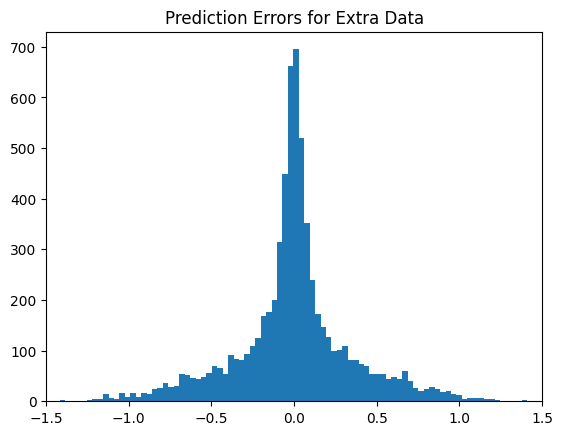

In [124]:
prediction_errors = mean_extra_predictions - extra_labels

plt.hist(prediction_errors, bins=100)

plt.title('Prediction Errors for Extra Data')
plt.xlim(-1.5, 1.5)

plt.show()

# Check prediction distributions

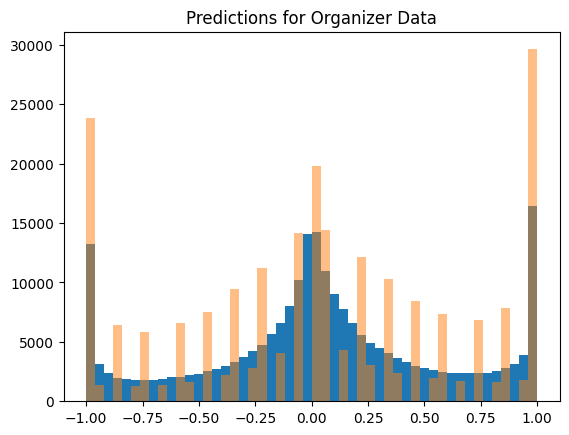

In [125]:
plt.hist(mean_organizer_predictions.clip(-1,1), bins=50)
plt.hist(organizer_labels, bins=50, alpha=0.5)
plt.title('Predictions for Organizer Data')
plt.show()

Text(0.5, 1.0, 'Predictions for Extra Data')

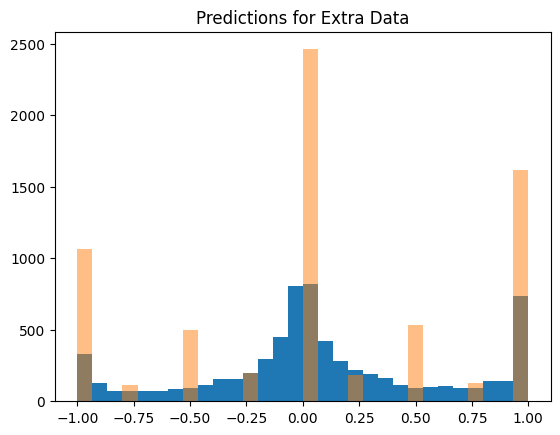

In [126]:
plt.hist(mean_extra_predictions.clip(-1,1), bins=30)
plt.hist(extra_labels, bins=30, alpha=0.5)
plt.title('Predictions for Extra Data')

# Investigate bootstrapping errors

In [334]:
baseline_organizer_predictions_path = 'predictions/00_00_v4_10fold_nested_organizer_bootstrapped_seed0.csv'
baseline_organizer_predictions_df = pd.read_csv(baseline_organizer_predictions_path)
baseline_organizer_predictions = baseline_organizer_predictions_df['prediction'].values.clip(-1,1)

rmse = root_mean_squared_error(baseline_organizer_predictions, organizer_labels)
r, p = pearsonr(baseline_organizer_predictions, organizer_labels)
print('No bootstrapping (rmse, r):', rmse, r)

bootstrapped_organizer_predictions_path = 'predictions/02_05_v4_10fold_nested_organizer_bootstrapped_seed0.csv'
bootstrapped_organizer_predictions_df = pd.read_csv(bootstrapped_organizer_predictions_path)
bootstrapped_organizer_predictions = bootstrapped_organizer_predictions_df['prediction'].values.clip(-1,1)

rmse = root_mean_squared_error(bootstrapped_organizer_predictions, organizer_labels)
r, p = pearsonr(bootstrapped_organizer_predictions, organizer_labels)
print('Bootstrapping (rmse, r):', rmse, r)


No bootstrapping (rmse, r): 0.368255513949385 0.8084561753996586
Bootstrapping (rmse, r): 0.36980473250863594 0.8066556459362518


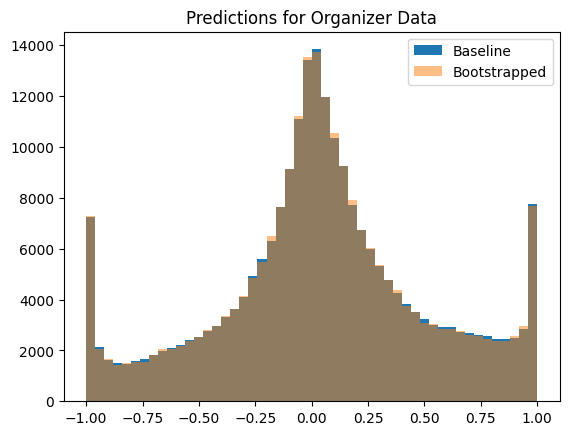

In [168]:
plt.hist(baseline_organizer_predictions.clip(-1,1), bins=50)
plt.hist(bootstrapped_organizer_predictions.clip(-1,1), bins=50, alpha=0.5)
plt.title('Predictions for Organizer Data')

plt.legend(['Baseline', 'Bootstrapped'])

plt.show()

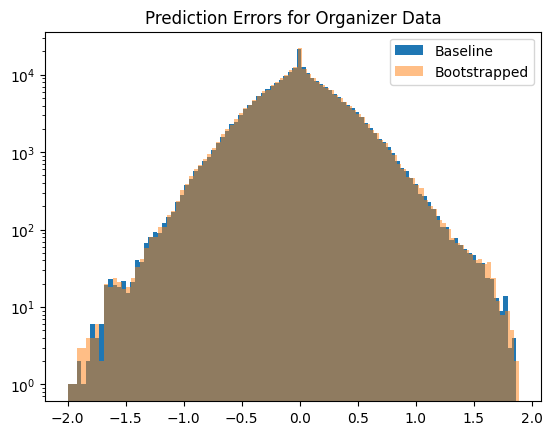

In [169]:
baseline_errors = baseline_organizer_predictions - organizer_labels
bootstrapped_errors = bootstrapped_organizer_predictions - organizer_labels

plt.hist(baseline_errors, bins=100)
plt.hist(bootstrapped_errors, bins=100, alpha=0.5)
plt.title('Prediction Errors for Organizer Data')
plt.legend(['Baseline', 'Bootstrapped'])

plt.yscale('log')

plt.show()

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GroupKFold

rmses = []
slopes = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index]
    test_predictions = baseline_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = LinearRegression(fit_intercept=False)
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    slope = model.coef_[0]
    slopes.append(slope)

    rmse = root_mean_squared_error(model.predict(test_predictions.reshape(-1, 1)).clip(-1,1), test_labels)
    rmses.append(rmse)

print(f'Slopes mean: {np.mean(slopes)} std: {np.std(slopes)}')
print('Baseline + linear RMSE:', np.mean(rmses))

Slopes mean: 1.073760042384514 std: 0.0030826410205042334
Baseline + linear RMSE: 0.3655056945972028


In [171]:
rmses = []
slopes = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
for train_index, test_index in kf.split(bootstrapped_organizer_predictions, organizer_labels, groups):
    train_predictions = bootstrapped_organizer_predictions[train_index]
    test_predictions = bootstrapped_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = LinearRegression(fit_intercept=False)
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    slopes.append(model.coef_[0])

    rmse = root_mean_squared_error(model.predict(test_predictions.reshape(-1, 1)).clip(-1,1), test_labels)
    rmses.append(rmse)

print(f'Slopes mean: {np.mean(slopes)}, std: {np.std(slopes)}')

print('Bootsrapped + linear RMSE:', np.mean(rmses))

Slopes mean: 1.0746048243402992, std: 0.003177770122110965
Bootsrapped + linear RMSE: 0.36700817590499885


# Determine optimal weight & clip values

In [360]:
from scipy.optimize import minimize

def GetRmse(hparams, predictions, labels, regularize=False):
    coef, magnitude, residual = hparams
    adjusted_predictions = (predictions * coef).clip(-magnitude, magnitude) + (residual*predictions)
    # adjusted_predictions = (predictions * coef - np.mean(predictions)/residual).clip(-magnitude, magnitude)
    rmse = root_mean_squared_error(adjusted_predictions, labels)

    regularization_factor = 0
    if regularize:
        regularization_factor = ((coef - 1)**2 + (magnitude - 1)**2)/10
        # regularization_factor = ((coef - 1)**2 + (magnitude - 1)**2)/1000

    return rmse + regularization_factor

rmses = []
coefs = []
magnitudes = []
residuals = []

kf = GroupKFold(n_splits=10)
groups = organizer_df['GameRulesetName'].values
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index]
    test_predictions = baseline_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]
    # train_labels = (organizer_labels + np.random.normal(0, 0.2, len(organizer_labels)))[train_index]
    # test_labels = (organizer_labels +  + np.random.normal(0, 0.2, len(organizer_labels)))[test_index]

    initial_guess = [1, 1, 0]
    result = minimize(
        GetRmse, 
        args = (train_predictions, train_labels, True),
        x0 = initial_guess, 
        bounds = [(0.9, 1.2), (0.5, 1), (0, 0)])

    coef, magnitude, residual = result.x

    adjusted_predictions = (test_predictions * coef).clip(-magnitude, magnitude) + residual*test_predictions
    # adjusted_predictions = (test_predictions * coef - np.mean(test_predictions)/residual).clip(-magnitude, magnitude)
    rmse = root_mean_squared_error(adjusted_predictions, test_labels)
    rmses.append(rmse)
    coefs.append(coef)
    magnitudes.append(magnitude)
    residuals.append(residual)

print(f'Baseline + optimized RMSE: {np.mean(rmses)}')
print(f'Coef mean: {np.mean(coefs)}, std: {np.std(coefs)}')
print(f'Magnitude mean: {np.mean(magnitudes)}, std: {np.std(magnitudes)}')
print(f'Residual mean: {np.mean(residuals)}, std: {np.std(residuals)}')

Baseline + optimized RMSE: 0.3653848843651231
Coef mean: 1.0784543133654478, std: 0.0033144698993537126
Magnitude mean: 0.987100465171838, std: 0.0006771988550685988
Residual mean: 0.0, std: 0.0


In [257]:
GetRmse([1.065, (1 + 0.966730784216432)/2, 0], baseline_organizer_predictions, organizer_labels, regularize=False)

0.36608069862015385

In [256]:
GetRmse([1.1, 0.98, 0], baseline_organizer_predictions, organizer_labels, regularize=False)

0.36556480463279023

# Try recalibrating with isotonic regression

In [283]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold, GroupKFold

rmses = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index]
    test_predictions = baseline_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = IsotonicRegression()
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    rmse = root_mean_squared_error(model.predict(test_predictions.reshape(-1, 1)).clip(-1,1), test_labels)
    rmses.append(rmse)

print('Baseline + isotonic RMSE:', np.mean(rmses))

Baseline + isotonic RMSE: 0.3649133687820008


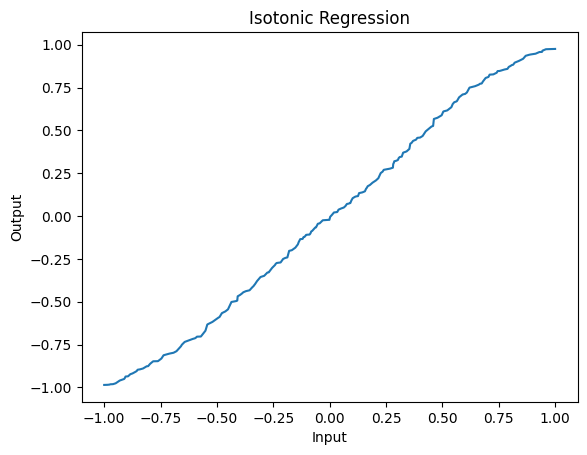

In [293]:
test_inputs = np.linspace(-1, 1, 10000)
test_outputs = model.predict(test_inputs.reshape(-1, 1))

plt.plot(test_inputs, test_outputs)
plt.title('Isotonic Regression')

plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

In [339]:
from cir_model import CenteredIsotonicRegression

rmses = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
cir_models = []
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index]
    test_predictions = baseline_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = CenteredIsotonicRegression()
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    rmse = root_mean_squared_error(model.predict(test_predictions.reshape(-1, 1)).clip(-1,1), test_labels)
    rmses.append(rmse)

    cir_models.append(model)

print('Baseline + centered isotonic RMSE:', np.mean(rmses))

Baseline + centered isotonic RMSE: 0.36487066296188064


Max adjustment: 0.11997381311421462
Min prediction: -0.9839654640764747
Max prediction: 0.9834363411619284


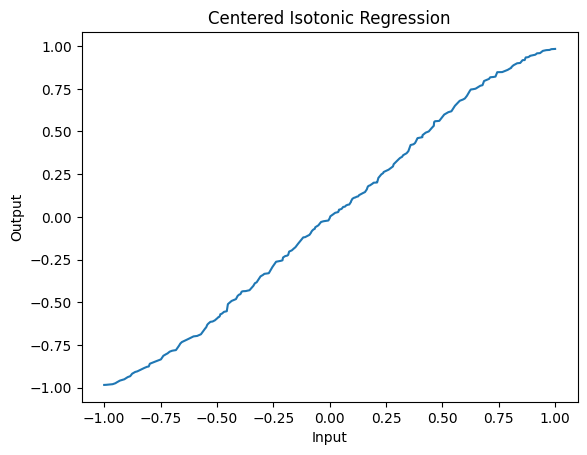

In [300]:
test_inputs = np.linspace(-1, 1, 10000)
test_outputs = np.mean([
    model.predict(test_inputs.reshape(-1, 1))
    for model in cir_models[:1]
], axis=0)

max_adjustment = np.max(np.abs(test_outputs - test_inputs))
print('Max adjustment:', max_adjustment)
print('Min prediction:', np.min(test_outputs))
print('Max prediction:', np.max(test_outputs))

plt.plot(test_inputs, test_outputs)
plt.title('Centered Isotonic Regression')

plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

In [299]:
test_input = np.linspace(-1, 1, 10000)
test_output = np.clip(test_input * 1.1317, -0.9667, 0.9667)

max_deviation = np.max(np.abs(test_output - test_input))
print(max_deviation)

0.1124962196219621


In [359]:
rmses = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
cir_models = []
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index].clip(-1, 1)
    test_predictions = baseline_organizer_predictions[test_index].clip(-1, 1)
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = CenteredIsotonicRegression()
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    scaled_predictions = model.predict(test_predictions.reshape(-1, 1)).clip(-1,1)
    
    residual_weight = 0.5
    scaled_predictions = (test_predictions * residual_weight) + ((1 - residual_weight) * scaled_predictions)

    rmse = root_mean_squared_error(scaled_predictions, test_labels)
    rmses.append(rmse)

    cir_models.append(model)

print('Baseline + centered isotonic with residual RMSE:', np.mean(rmses))

Baseline + centered isotonic with residual RMSE: 0.3655012136196747


In [312]:
import joblib

joblib.dump(cir_models, 'models/cir_models_v1.p')

['models/cir_models_v1.p']

In [358]:
from cir_model import CenteredIsotonicRegression
from scipy.interpolate import PchipInterpolator

rmses = []

groups = organizer_df['GameRulesetName'].values
kf = GroupKFold(n_splits=10)
cir_models = []
for train_index, test_index in kf.split(baseline_organizer_predictions, organizer_labels, groups):
    train_predictions = baseline_organizer_predictions[train_index]
    test_predictions = baseline_organizer_predictions[test_index]
    train_labels = organizer_labels[train_index]
    test_labels = organizer_labels[test_index]

    model = CenteredIsotonicRegression()
    model.fit(train_predictions.reshape(-1, 1), train_labels)

    interpolators = []
    for i in range(100):
        sample_inputs = np.sort(np.random.uniform(-1, 1, 500))
        sample_outputs = model.predict(sample_inputs.reshape(-1, 1))
        interpolator = PchipInterpolator(sample_inputs, sample_outputs)
        interpolators.append(interpolator)

    test_predictions = np.mean([
        interpolator(test_predictions)
        for interpolator in interpolators
    ], axis=0)

    # test_predictions = test_predictions*0.95 + 0.05*model.predict(test_predictions.reshape(-1, 1))

    rmse = root_mean_squared_error(test_predictions.reshape(-1, 1), test_labels)
    rmses.append(rmse)

    cir_models.append(model)

print('Baseline + smoothed centered isotonic RMSE:', np.mean(rmses))

Baseline + smoothed centered isotonic RMSE: 0.36486201178258454
